In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
from fastai.text import *
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re,string,unicodedata
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load in Dataset

In [5]:
path = Path('data')

In [6]:
df = pd.read_json(path/"Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,1
1,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...,0
2,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes,0
3,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,1
4,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...,1


# Preprocessing and Visualization

Preprocessing inspired by https://www.kaggle.com/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy

In [7]:
df.isna().sum() # Checking for NaN values

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [8]:
del df['article_link'] # Deleting this column as it is of no use

In [9]:
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


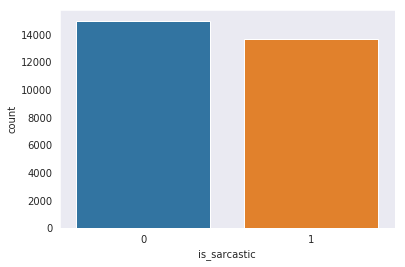

In [11]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

### Remove stopwords

In [16]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [17]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [18]:
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

In [19]:
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails congress falling short ...,0
2,eat veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar getting work,1
4,mother comes pretty close using word 'streamin...,1


### Number of Words in each class

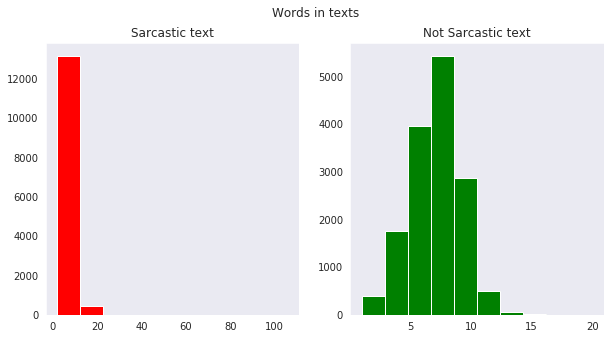

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

### Average word length in each class

Text(0.5, 0.98, 'Average word length in each text')

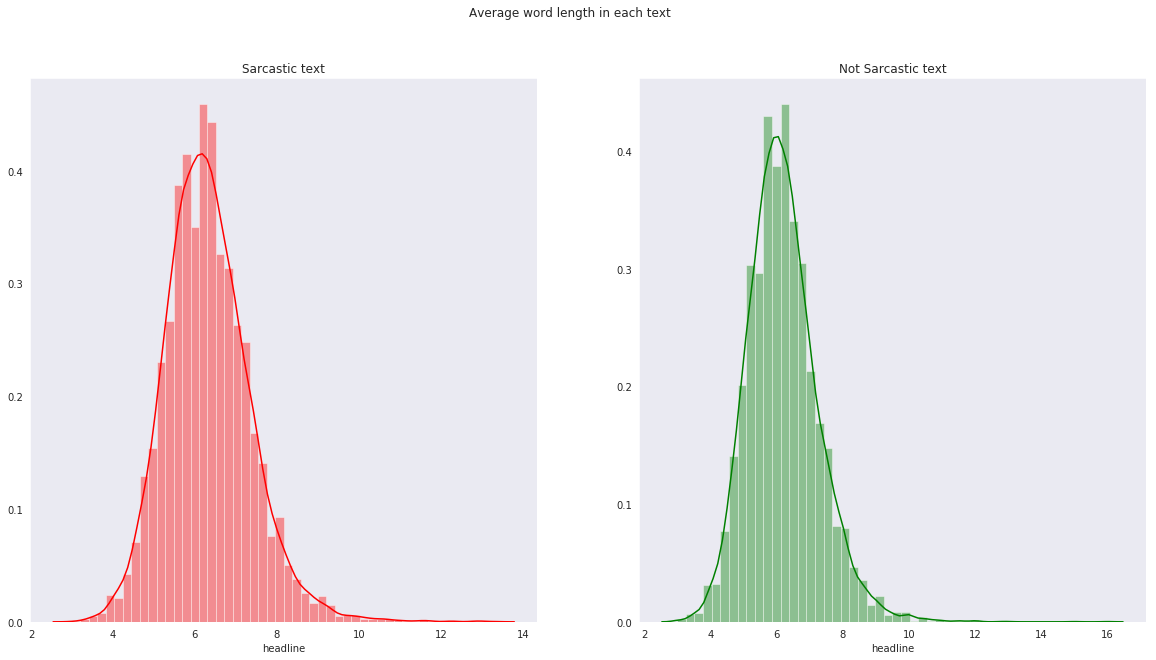

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

### Write to csv for Language Model

In [30]:
df.head()
df.to_csv(path/'data_lm.csv', index=True)  

# Load dataframe into Fastai data bunch

In [23]:
bs=10

In [ ]:
data = (TextList.from_df(df, '.', cols='headline')
                .split_by_rand_pct() #randomly split with the default 20% in valid
                .label_from_df(cols=0)
                .databunch(bs=bs))

In [ ]:
data.show_batch()

In [ ]:
data.c #number of classes

# Train Langauge Model

In [24]:
bs=10

In [31]:
data_lm = (TextList.from_csv(path, 'data_lm.csv', cols='headline')
                .split_by_rand_pct() #randomly split with the default 20% in valid
                .label_from_df(cols=0)
                .label_for_lm()          
                .databunch(bs=10))

/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
6604, 26297, 16453, 1868, 14565...
  if getattr(ds, 'warn', False): warn(ds.warn)


In [33]:
data_lm.save('data_lm.pkl')

In [34]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [35]:
data_lm.show_batch()

idx,text
0,[ 2 xxunk 85 xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk xxunk 9 xxunk xxunk xxunk 9 ] xxbos [ 2 xxunk xxunk 15 xxunk xxunk 0 xxunk ] xxbos [ 2 25 16 xxunk 0 ] xxbos [ 2 xxunk xxunk xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk ] xxbos [ 2 xxunk 79 xxunk xxunk xxunk xxunk xxunk
1,xxunk 11 xxunk xxunk xxunk 47 xxunk xxunk ] xxbos [ 2 xxunk xxunk 0 xxunk xxunk xxunk xxunk xxunk ] xxbos [ 2 27 17 0 xxunk xxunk xxunk ] xxbos [ 2 xxunk xxunk 9 xxunk xxunk 9 0 ] xxbos [ 2 xxunk xxunk 91 xxunk xxunk xxunk 0 xxunk 0 ] xxbos [ 2 xxunk xxunk xxunk xxunk xxunk xxunk 15 0 xxunk ] xxbos [
2,12 500 0 ] xxbos [ 2 9 xxunk xxunk xxunk 0 0 9 ] xxbos [ 2 xxunk xxunk 22 ] xxbos [ 2 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk 28 22 15 xxunk 96 xxunk ] xxbos [ 2 27 17 xxunk xxunk xxunk 0 12 xxunk xxunk xxunk ] xxbos [ 2 25 16 xxunk xxunk 87
3,xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk 0 xxunk xxunk xxunk ] xxbos [ 2 xxunk 9 69 80 0 9 xxunk ] xxbos [ 2 xxunk xxunk 0 xxunk xxunk 45 xxunk xxunk ] xxbos [ 2 xxunk xxunk 10 xxunk xxunk 14 xxunk xxunk xxunk ] xxbos [ 2 xxunk xxunk xxunk 26 14 ] xxbos [ 2 xxunk xxunk xxunk 0 xxunk 12 xxunk 0
4,] xxbos [ 2 xxunk xxunk 50 xxunk ] xxbos [ 2 xxunk xxunk xxunk xxunk ] xxbos [ 2 xxunk xxunk 10 xxunk 56 xxunk xxunk 28 xxunk xxunk ] xxbos [ 2 xxunk 16 xxunk 41 85 40 32 ] xxbos [ 2 0 xxunk 92 xxunk 12 72 xxunk xxunk xxunk ] xxbos [ 2 0 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk 10 xxunk ]


In [36]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [37]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


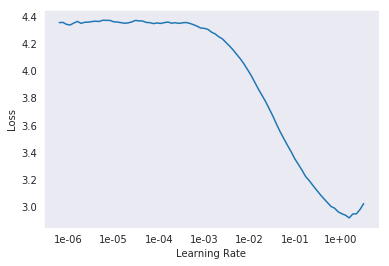

In [38]:
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [40]:
learn.save('fit_head')

In [41]:
learn.load('fit_head');

In [42]:
learn.unfreeze()

In [43]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

In [44]:
learn.save('fine_tuned')

In [45]:
learn.load('fine_tuned');

In [74]:
TEXT = "The United States"
N_WORDS = 10
N_SENTENCES = 5

In [79]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.5) for _ in range(N_SENTENCES)))

The United States and Canada Center of Canada West
The United States of America West Africa ( US
The United States senator , Governor George W. Stevens
The United States of America West Virginia State
The United States of America South Africa was to support


### Save the Encoder
The first half of the Language Model that Understands the Sentence 

In [80]:
learn.save_encoder('fine_tuned_enc')

# Train Classifier Model

Important to load in the language model vocab

In [86]:
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails congress falling short ...,0
2,eat veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar getting work,1
4,mother comes pretty close using word 'streamin...,1


In [87]:
data_classifier = (TextList.from_df(df, '.', cols='headline', vocab=data_lm.vocab)
                .split_by_rand_pct() #randomly split with the default 20% in valid
                .label_from_df(cols=1)
                .databunch(bs=10))

In [88]:
data_classifier.save(path/'data_classifier.pkl')

In [89]:
data_classifier = load_data(path, 'data_classifier.pkl', bs=bs)

In [90]:
data_classifier.show_batch()

text,target
"xxbos ' 12 years slave , ' ' captain xxunk , ' ' american xxunk , ' ' wolf wall street , ' ' blue xxunk , ' ' dallas buyers club , ' ' her , ' ' xxunk , ' ' before midnight , ' ' xxunk ' written continuing education screenwriting class",1
"xxbos ' i 'd like post long , aggressive xxunk social media , ' says bernie sanders supporter 's interpretation speech",1
"xxbos aides clip toenails , wash hair xxunk , xxunk - ridden trump president enters xxunk straight hour watching cable news",1
xxbos cbs reveals ' big bang theory ' season 12 explore sheldon keeps job sexually harassing 6 research assistants,1
xxbos sexual assault survivors ' rights act 2016 : ' our nation 's laws stand xxunk side survivors ',0


In [91]:
learn = text_classifier_learner(data_classifier, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc');

In [92]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


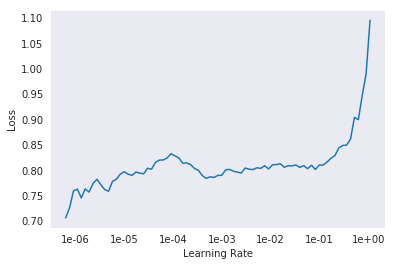

In [93]:
learn.recorder.plot()

In [94]:
learn.fit_one_cycle(1, 2e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.666646,0.570864,0.721999,00:46


In [95]:
learn.save('classifier-stage-1')

In [96]:
learn.unfreeze()

In [97]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


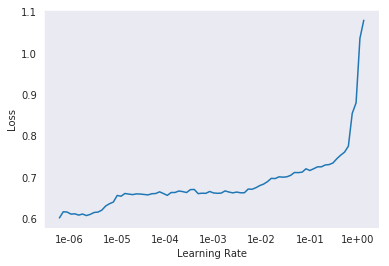

In [98]:
learn.recorder.plot()

In [99]:
learn.fit_one_cycle(3, 3e-6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.647170,0.571890,0.717281,01:00
1,0.654337,0.565337,0.729862,00:59
2,0.645379,0.565494,0.728988,01:00


In [100]:
learn.save('classifier-stage-2')

# Test Predictions

### Sarcastic Headlines

In [104]:
learn.predict("City Enters Phase 4 Of Pretending Coronavirus Over") 
# Prediction =  sarcastic

(Category 1, tensor(1), tensor([0.1951, 0.8049]))

In [105]:
learn.predict("10 Breathtaking Photos That Perfectly Capture The Unwavering Spirit Of Scissors") 
# Prediction =  not sarcastic

(Category 0, tensor(0), tensor([0.5994, 0.4006]))

In [106]:
learn.predict("Sony Reveals PS5 Fully Customizable With Different Little Hats") 
# Prediction =  sarcastic

(Category 1, tensor(1), tensor([0.0953, 0.9047]))

In [110]:
learn.predict("Heavily Armed Self-Help Gurus Demand America Reopens Their Hearts") 
# Prediction =  sarcastic

(Category 1, tensor(1), tensor([0.4715, 0.5285]))

### Non Sarcastic Headlines

In [107]:
learn.predict("Texas governor urges people to stay home as states report surges of new Covid-19 cases") 
# Prediction =  sarcastic

(Category 1, tensor(1), tensor([0.2181, 0.7819]))

In [108]:
learn.predict("Orlando bar liquor license suspended after dozens of patrons and workers test positive for coronavirus") 
# Prediction = not sarcastic

(Category 0, tensor(0), tensor([0.5031, 0.4969]))

In [109]:
learn.predict("McDonald's is closing its iconic Times Square location") 
# Prediction = not sarcastic

(Category 0, tensor(0), tensor([0.6493, 0.3507]))

In [111]:
learn.predict("Disney World workers petition to delay reopening as Florida coronavirus cases surge") 
# Prediction = sarcastic

(Category 1, tensor(1), tensor([0.4075, 0.5925]))

In [112]:
learn.predict("Black Eyed Peas explain Fergie's absence") 
# Prediction = sarcastic

(Category 1, tensor(1), tensor([0.4897, 0.5103]))